In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn.functional as F
import torchvision.transforms as T

from PIL import Image
import json
from math import prod
from huggingface_hub import hf_hub_download
import tqdm
transform_t_to_pil = T.ToPILImage()
transform_to_t = transforms.Compose([transforms.ToTensor()])
import utils
from utils import get_all_bounding_boxes, segment, calculate_initial_theta, stack_alpha_aware, AestheticPredictor
from lion_pytorch import Lion
from datetime import datetime
import random

In [2]:
im = Image.open('combined/5373.jpg')
im = im.convert('RGBA')
im = im.resize((1440, 2560), Image.Resampling.LANCZOS)


with open("combined/5373.json", "r") as f:
    image_json = json.load(f)

reduced_segments = [s for s in segment(im,image_json) if (prod(s[0].size) < 0.80*prod(im.size)) and (prod(s[0].size)>1)]
even_more_reduced_segments = [reduced_segments[i] for i in [2,4,5,6,7,8,10,11,12]]

In [3]:
class MultiSegmentUIOptimizerWithBackgroundParam(torch.nn.Module):
    def __init__(self,segments_and_positions: list, original_image_size: tuple):
        super().__init__()
        self.original_image_size = original_image_size
        self.segments_and_positions = segments_and_positions
        self.canvas_size = (1,3,original_image_size[1],original_image_size[0])
        print(f"Canvas size is {self.canvas_size}")

        initial_vector = []
        for segment,position in segments_and_positions:
            # initial_theta = calculate_initial_theta(segment,original_image_size,position)
            initial_theta = get_random_initial_position(segment,original_image_size,position)
            initial_vector.append([initial_theta[0][2],initial_theta[1][2]])

        self.coordinates = torch.nn.Parameter(torch.tensor(initial_vector))
        print(self.coordinates)
        self.background_color = torch.nn.Parameter(torch.tensor(np.array([1.0,1.0,1.0]),dtype=torch.float))
        

    def forward(self):
        segments_on_canvas = []

        # Create background image from parameter
        bg_col = torch.clamp(self.background_color, min=0, max=1)
        #print(f"Clamped bg to {bg_col}")
        red = torch.tile(bg_col[0],self.original_image_size[::-1])
        green = torch.tile(bg_col[1],self.original_image_size[::-1])
        blue = torch.tile(bg_col[2],self.original_image_size[::-1])
        alpha = torch.tile(torch.tensor(0.0),self.original_image_size[::-1])
        background = torch.stack([red,green,blue,alpha]).unsqueeze(0)
        #print(background.detach().sum())
        #background = torch.tile(self.background_color,self.original_image_size)
        
        
        for n in range(len(self.segments_and_positions)):
            # We need to calculate the proper ratios, to artificially warp the segment on to a bigger canvas without distorting it (see notebook 01)
            x_ratio = self.original_image_size[0] / self.segments_and_positions[n][0].size[0]
            y_ratio = self.original_image_size[1] / self.segments_and_positions[n][0].size[1]
            
            # Affine matrix
            theta = [
                [x_ratio, 0.0    , 0.0],
                [0.0    , y_ratio, 0.0]
            ]
            theta_tensor = torch.as_tensor(theta)[None]

            theta_tensor[0][0][2]+=self.coordinates[n][0]
            theta_tensor[0][1][2]+=self.coordinates[n][1]
            
            # Generate flow field
            grid = F.affine_grid(theta_tensor, self.canvas_size).type(torch.FloatTensor)
            x = F.grid_sample(transform_to_t(self.segments_and_positions[n][0]).unsqueeze(0), grid)
            segments_on_canvas.append(x)

        segments_on_canvas.append(background)

        return segments_on_canvas

In [4]:
def get_random_initial_position(segment, canvas_size, original_position, seed=1):
    # random.seed(seed)

    
    # Theta consists of 6 values, 4 of which we have to calculate.
    x_ratio = canvas_size[0] / segment.size[0]
    y_ratio = canvas_size[1] / segment.size[1]
    
    mapped_x_position = random.uniform(-(x_ratio-1), (x_ratio-1))
    mapped_y_position = random.uniform(-(y_ratio-1), (y_ratio-1))

    print(f"Original would have been: {calculate_initial_theta(segment,canvas_size,original_position)}")
    print(f"""Now is {np.array([ 
        [x_ratio, 0.0    , mapped_x_position],
        [0.0    , y_ratio, mapped_y_position]
    ])}""")

    
    return np.array([
        [x_ratio, 0.0    , mapped_x_position],
        [0.0    , y_ratio, mapped_y_position]
    ])

In [5]:
msUIo_wbg = MultiSegmentUIOptimizerWithBackgroundParam(even_more_reduced_segments, im.size)

Canvas size is (1, 3, 2560, 1440)
Original would have been: [[ 8.57142857  0.         -5.8047619 ]
 [ 0.         15.23809524 13.30372024]]
Now is [[ 8.57142857e+00  0.00000000e+00 -4.86438813e-03]
 [ 0.00000000e+00  1.52380952e+01  2.57243878e-01]]
Original would have been: [[ 2.93279022  0.          1.63213397]
 [ 0.         27.52688172 21.30440188]]
Now is [[ 2.93279022  0.          1.160904  ]
 [ 0.         27.52688172  6.64493145]]
Original would have been: [[ 1.69811321  0.          0.58951782]
 [ 0.         18.02816901 12.06605414]]
Now is [[ 1.69811321  0.         -0.4312855 ]
 [ 0.         18.02816901 13.82862905]]
Original would have been: [[ 1.62162162  0.          0.52492492]
 [ 0.         10.5785124   5.30559788]]
Now is [[ 1.62162162  0.         -0.41210195]
 [ 0.         10.5785124   3.50967461]]
Original would have been: [[ 2.67657993  0.          1.4157786 ]
 [ 0.         33.68421053 11.20966283]]
Now is [[ 2.67657993  0.         -1.15601857]
 [ 0.         33.68421053 -

/Users/mowoe/Documents/bachelorthesis/venv/lib/python3.11/site-packages/torch/nn/functional.py:4377: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/Users/mowoe/Documents/bachelorthesis/venv/lib/python3.11/site-packages/torch/nn/functional.py:4316: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


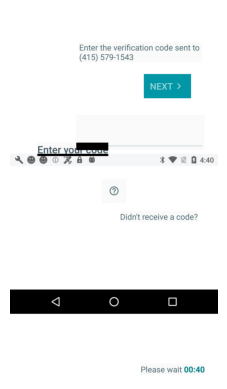

In [6]:
canvasses = msUIo_wbg()


generated_image = stack_alpha_aware(canvasses)
# Remove Alpha channel
generated_image = generated_image[:3]

plt.imshow(generated_image.detach().permute(1, 2, 0))

plt.axis('off')
plt.show()

In [7]:
appsthetics_predictor = torch.load("./resnet_50_20_epochs_2024-05-13T14:03")

In [8]:
appsthetics_predictor.eval()
1

1

In [9]:
# optimizer = Lion(msUIo_wbg.parameters(), lr=0.005)
optimizer = torch.optim.AdamW(msUIo_wbg.parameters(), lr=0.1)

In [10]:
scores = []
images_for_gif = []

for x in tqdm.tqdm(range(500)):
    optimizer.zero_grad()
    canvasses = msUIo_wbg()
    
    generated_image = stack_alpha_aware(canvasses)
    # Remove Alpha channel
    generated_image = generated_image[:3]

    score = appsthetics_predictor(generated_image.unsqueeze(0))
    print(score.detach().item())

    loss = -score
    loss.backward()
    optimizer.step()

    scores.append(score.detach().item())

    # Save image as png to create gif
    pil_image = transform_t_to_pil(generated_image.detach())
    pil_image = pil_image.resize((int(pil_image.size[0]/4),int(pil_image.size[1]/4)), Image.Resampling.LANCZOS)
    pil_image.save(f"{x}.png")
    images_for_gif.append(f"{x}.png")
    #pbar.set_description(f"Score: {score}")
    #pbar.refresh()

print(f"Final Score: {score[-1]}")

  0%|                                                                                                                                                                                                        | 0/500 [00:00<?, ?it/s]

0.3286224901676178


  0%|▍                                                                                                                                                                                             | 1/500 [00:11<1:36:37, 11.62s/it]

0.3390066921710968


  0%|▊                                                                                                                                                                                             | 2/500 [00:21<1:28:09, 10.62s/it]

0.30920538306236267


  1%|█▏                                                                                                                                                                                            | 3/500 [00:31<1:23:53, 10.13s/it]

0.33513617515563965


  1%|█▌                                                                                                                                                                                            | 4/500 [00:40<1:20:33,  9.75s/it]

0.3098880350589752


  1%|█▉                                                                                                                                                                                            | 5/500 [00:49<1:19:23,  9.62s/it]

0.3174095153808594


  1%|██▎                                                                                                                                                                                           | 6/500 [00:59<1:18:29,  9.53s/it]

0.3129926323890686


  1%|██▋                                                                                                                                                                                           | 7/500 [01:08<1:18:19,  9.53s/it]

0.3022385835647583


  2%|███                                                                                                                                                                                           | 8/500 [01:17<1:17:57,  9.51s/it]

0.31103000044822693


  2%|███▍                                                                                                                                                                                          | 9/500 [01:28<1:19:54,  9.77s/it]

0.3124968409538269


  2%|███▊                                                                                                                                                                                         | 10/500 [01:37<1:19:27,  9.73s/it]

0.3205869197845459


  2%|████▏                                                                                                                                                                                        | 11/500 [01:48<1:20:51,  9.92s/it]

0.3308694064617157


  2%|████▌                                                                                                                                                                                        | 12/500 [02:00<1:25:11, 10.47s/it]

0.30849894881248474


  3%|████▉                                                                                                                                                                                        | 13/500 [02:14<1:35:07, 11.72s/it]

0.32126113772392273


  3%|█████▎                                                                                                                                                                                       | 14/500 [02:31<1:47:59, 13.33s/it]

0.3103431165218353


  3%|█████▋                                                                                                                                                                                       | 15/500 [02:48<1:56:58, 14.47s/it]

0.33908742666244507


  3%|██████                                                                                                                                                                                       | 16/500 [03:03<1:57:27, 14.56s/it]

0.29067525267601013


  3%|██████▍                                                                                                                                                                                      | 17/500 [03:17<1:55:10, 14.31s/it]

0.27846941351890564


  4%|██████▊                                                                                                                                                                                      | 18/500 [03:29<1:50:47, 13.79s/it]

0.3460404872894287


  4%|███████▏                                                                                                                                                                                     | 19/500 [03:41<1:45:43, 13.19s/it]

0.3438594341278076


  4%|███████▌                                                                                                                                                                                     | 20/500 [03:53<1:41:17, 12.66s/it]

0.3268080949783325


  4%|███████▉                                                                                                                                                                                     | 21/500 [04:04<1:37:43, 12.24s/it]

0.3267800211906433


  4%|████████▎                                                                                                                                                                                    | 22/500 [04:16<1:36:09, 12.07s/it]

0.3341203033924103


  5%|████████▋                                                                                                                                                                                    | 23/500 [04:28<1:36:52, 12.19s/it]

0.32692015171051025


  5%|█████████                                                                                                                                                                                    | 24/500 [04:42<1:41:13, 12.76s/it]

0.33509209752082825


  5%|█████████▍                                                                                                                                                                                   | 25/500 [04:55<1:41:31, 12.82s/it]

0.3314090967178345


  5%|█████████▊                                                                                                                                                                                   | 26/500 [05:08<1:40:41, 12.75s/it]

0.322845458984375


  5%|██████████▏                                                                                                                                                                                  | 27/500 [05:21<1:43:05, 13.08s/it]

0.3201442062854767


  6%|██████████▌                                                                                                                                                                                  | 28/500 [05:52<2:23:14, 18.21s/it]

0.33898091316223145


  6%|██████████▉                                                                                                                                                                                  | 29/500 [06:09<2:20:15, 17.87s/it]

0.3499318063259125


  6%|███████████▎                                                                                                                                                                                 | 30/500 [06:25<2:15:52, 17.35s/it]

0.30761992931365967


  6%|███████████▋                                                                                                                                                                                 | 31/500 [06:39<2:06:58, 16.24s/it]

0.3231406807899475


  6%|████████████                                                                                                                                                                                 | 32/500 [06:51<1:58:19, 15.17s/it]

0.3547440767288208


  7%|████████████▍                                                                                                                                                                                | 33/500 [07:04<1:51:21, 14.31s/it]

0.3399299085140228


  7%|████████████▊                                                                                                                                                                                | 34/500 [07:16<1:47:19, 13.82s/it]

0.3295481204986572


  7%|█████████████▏                                                                                                                                                                               | 35/500 [07:29<1:44:43, 13.51s/it]

0.32484495639801025


  7%|█████████████▌                                                                                                                                                                               | 36/500 [07:42<1:43:29, 13.38s/it]

0.33479273319244385


  7%|█████████████▉                                                                                                                                                                               | 37/500 [07:55<1:41:41, 13.18s/it]

0.3479488790035248


  8%|██████████████▎                                                                                                                                                                              | 38/500 [08:07<1:40:18, 13.03s/it]

0.3298947215080261


  8%|██████████████▋                                                                                                                                                                              | 39/500 [08:20<1:38:37, 12.84s/it]

0.3437541425228119


  8%|███████████████                                                                                                                                                                              | 40/500 [08:36<1:45:08, 13.71s/it]

0.3435834050178528


  8%|███████████████▍                                                                                                                                                                             | 41/500 [08:48<1:41:20, 13.25s/it]

0.33121660351753235


  8%|███████████████▉                                                                                                                                                                             | 42/500 [09:02<1:42:46, 13.46s/it]

0.32284659147262573


  9%|████████████████▎                                                                                                                                                                            | 43/500 [09:15<1:41:48, 13.37s/it]

0.31506115198135376


  9%|████████████████▋                                                                                                                                                                            | 44/500 [09:28<1:40:34, 13.23s/it]

0.3225487768650055


  9%|█████████████████                                                                                                                                                                            | 45/500 [09:41<1:41:17, 13.36s/it]

0.34896183013916016


  9%|█████████████████▍                                                                                                                                                                           | 46/500 [09:55<1:41:19, 13.39s/it]

0.33312079310417175


  9%|█████████████████▊                                                                                                                                                                           | 47/500 [10:07<1:37:41, 12.94s/it]

0.34699925780296326


 10%|██████████████████▏                                                                                                                                                                          | 48/500 [10:18<1:34:06, 12.49s/it]

0.3382844924926758


 10%|██████████████████▌                                                                                                                                                                          | 49/500 [10:29<1:31:07, 12.12s/it]

0.34291619062423706


 10%|██████████████████▉                                                                                                                                                                          | 50/500 [10:41<1:30:18, 12.04s/it]

0.338296502828598


 10%|███████████████████▎                                                                                                                                                                         | 51/500 [10:54<1:31:13, 12.19s/it]

0.34507399797439575


 10%|███████████████████▋                                                                                                                                                                         | 52/500 [11:06<1:30:18, 12.09s/it]

0.34645119309425354


 11%|████████████████████                                                                                                                                                                         | 53/500 [11:19<1:33:01, 12.49s/it]

0.3563457131385803


 11%|████████████████████▍                                                                                                                                                                        | 54/500 [11:32<1:33:09, 12.53s/it]

0.360298752784729


 11%|████████████████████▊                                                                                                                                                                        | 55/500 [11:45<1:35:15, 12.84s/it]

0.35194477438926697


 11%|█████████████████████▏                                                                                                                                                                       | 56/500 [11:58<1:35:25, 12.90s/it]

0.33686333894729614


 11%|█████████████████████▌                                                                                                                                                                       | 57/500 [12:13<1:39:14, 13.44s/it]

0.34218066930770874


 12%|█████████████████████▉                                                                                                                                                                       | 58/500 [12:27<1:41:07, 13.73s/it]

0.3477305471897125


 12%|██████████████████████▎                                                                                                                                                                      | 59/500 [12:40<1:38:04, 13.34s/it]

0.35012465715408325


 12%|██████████████████████▋                                                                                                                                                                      | 60/500 [12:52<1:35:01, 12.96s/it]

0.3563844561576843


 12%|███████████████████████                                                                                                                                                                      | 61/500 [13:06<1:36:09, 13.14s/it]

0.34271082282066345


 12%|███████████████████████▍                                                                                                                                                                     | 62/500 [13:20<1:38:19, 13.47s/it]

0.3389080762863159


 13%|███████████████████████▊                                                                                                                                                                     | 63/500 [13:33<1:37:35, 13.40s/it]

0.3533205986022949


 13%|████████████████████████▏                                                                                                                                                                    | 64/500 [13:46<1:37:22, 13.40s/it]

0.3526318073272705


 13%|████████████████████████▌                                                                                                                                                                    | 65/500 [14:00<1:37:41, 13.47s/it]

0.3496829867362976


 13%|████████████████████████▉                                                                                                                                                                    | 66/500 [14:18<1:47:07, 14.81s/it]

0.3506709039211273


 13%|█████████████████████████▎                                                                                                                                                                   | 67/500 [14:33<1:46:22, 14.74s/it]

0.33822116255760193


 14%|█████████████████████████▋                                                                                                                                                                   | 68/500 [14:46<1:42:14, 14.20s/it]

0.3354538381099701


 14%|██████████████████████████                                                                                                                                                                   | 69/500 [14:58<1:37:30, 13.57s/it]

0.35564789175987244


 14%|██████████████████████████▍                                                                                                                                                                  | 70/500 [15:13<1:40:10, 13.98s/it]

0.33477967977523804


 14%|██████████████████████████▊                                                                                                                                                                  | 71/500 [15:27<1:41:22, 14.18s/it]

0.34038254618644714


 14%|███████████████████████████▏                                                                                                                                                                 | 72/500 [15:40<1:37:45, 13.70s/it]

0.3397700786590576


 15%|███████████████████████████▌                                                                                                                                                                 | 73/500 [15:53<1:37:29, 13.70s/it]

0.3553091287612915


 15%|███████████████████████████▉                                                                                                                                                                 | 74/500 [16:06<1:34:43, 13.34s/it]

0.35441887378692627


 15%|████████████████████████████▎                                                                                                                                                                | 75/500 [16:18<1:31:33, 12.93s/it]

0.355873703956604


 15%|████████████████████████████▋                                                                                                                                                                | 76/500 [16:35<1:39:20, 14.06s/it]

0.34086036682128906


 15%|█████████████████████████████                                                                                                                                                                | 77/500 [16:47<1:36:05, 13.63s/it]

0.33557021617889404


 16%|█████████████████████████████▍                                                                                                                                                               | 78/500 [17:00<1:33:03, 13.23s/it]

0.34440791606903076


 16%|█████████████████████████████▊                                                                                                                                                               | 79/500 [17:18<1:32:16, 13.15s/it]


KeyboardInterrupt: 

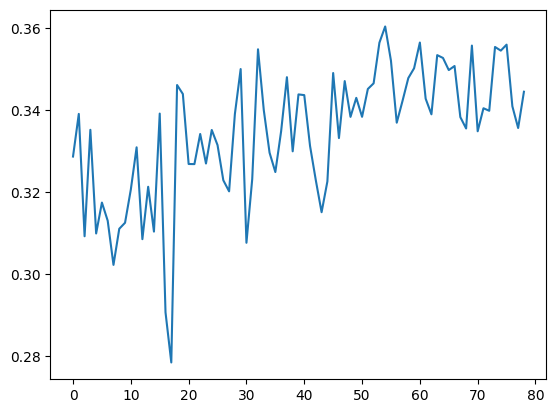

In [11]:
plt.plot(scores)
plt.show()

/var/folders/zp/wdq5n2513f916zsjngb1hs_c0000gn/T/ipykernel_32399/979258874.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))
/var/folders/zp/wdq5n2513f916zsjngb1hs_c0000gn/T/ipykernel_32399/979258874.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML



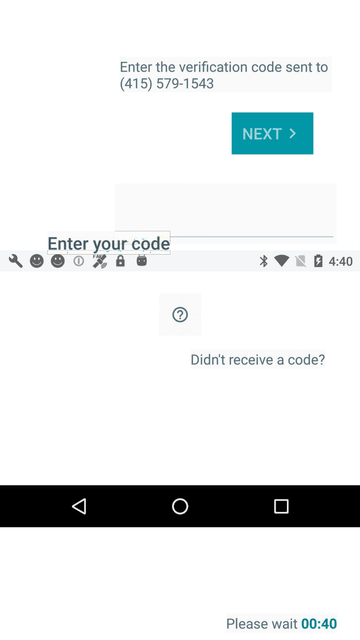

In [12]:
# Create gif from steps
import imageio

images = []
for filename in images_for_gif:
    images.append(imageio.imread(filename))

gif_filename = f"./progress_{datetime.now().isoformat(timespec='minutes')}.gif"
imageio.mimsave(gif_filename, images, loop=65535)

import base64
from IPython.core.display import display, HTML

b64 = base64.b64encode(open(gif_filename,'rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))

In [ ]:
new_image = (generated_image[0]*0.299+generated_image[1]*0.587+generated_image[2]*0.114)

In [ ]:
new_image.shape

In [ ]:
rgb_grayscale_im = torch.stack([new_image,new_image,new_image])

In [ ]:
rgb_grayscale_im.shape

In [ ]:
grayscale_pil = transform_t_to_pil(rgb_grayscale_im)
im.resize((1440, 2560), Image.Resampling.LANCZOS)
display(grayscale_pil.resize((int(grayscale_pil.size[0]/4),int(grayscale_pil.size[1]/4)),Image.Resampling.LANCZOS))

Lets apply this to our optimiser:

In [13]:
scores = []
images_for_gif = []
msUIo_wbg_gr = MultiSegmentUIOptimizerWithBackgroundParam(even_more_reduced_segments, im.size)
optimizer = torch.optim.AdamW(msUIo_wbg_gr.parameters(), lr=0.01)
for x in tqdm.tqdm(range(200)):
    optimizer.zero_grad()
    canvasses = msUIo_wbg_gr()
    
    generated_image = stack_alpha_aware(canvasses)
    # Remove Alpha channel
    generated_image = generated_image[:3]

    # Convert to grayscale
    new_image = (generated_image[0]*0.299+generated_image[1]*0.587+generated_image[2]*0.114)
    rgb_grayscale_im = torch.stack([new_image,new_image,new_image])

    #score = appsthetics_predictor(generated_image.unsqueeze(0))
    score = appsthetics_predictor(rgb_grayscale_im.unsqueeze(0))
    print(score)

    loss = -score
    loss.backward()
    optimizer.step()

    scores.append(score.item())

    # Save image as png to create gif
    #pil_image = transform_t_to_pil(generated_image.detach())
    pil_image = transform_t_to_pil(rgb_grayscale_im.detach())
    pil_image = pil_image.resize((int(pil_image.size[0]/4),int(pil_image.size[1]/4)), Image.Resampling.LANCZOS)
    pil_image.save(f"{x}.png")
    images_for_gif.append(f"{x}.png")
    #pbar.set_description(f"Score: {score}")
    #pbar.refresh()

print(f"Final Score: {score[-1]}")

Canvas size is (1, 3, 2560, 1440)
Original would have been: [[ 8.57142857  0.         -5.8047619 ]
 [ 0.         15.23809524 13.30372024]]
Now is [[ 8.57142857  0.          3.61167412]
 [ 0.         15.23809524  3.96971119]]
Original would have been: [[ 2.93279022  0.          1.63213397]
 [ 0.         27.52688172 21.30440188]]
Now is [[ 2.93279022  0.         -0.0426598 ]
 [ 0.         27.52688172 14.52377524]]
Original would have been: [[ 1.69811321  0.          0.58951782]
 [ 0.         18.02816901 12.06605414]]
Now is [[  1.69811321   0.          -0.27773424]
 [  0.          18.02816901 -15.43065236]]
Original would have been: [[ 1.62162162  0.          0.52492492]
 [ 0.         10.5785124   5.30559788]]
Now is [[ 1.62162162  0.          0.58785104]
 [ 0.         10.5785124   1.26737007]]
Original would have been: [[ 2.67657993  0.          1.4157786 ]
 [ 0.         33.68421053 11.20966283]]
Now is [[ 2.67657993  0.         -1.08550263]
 [ 0.         33.68421053 -2.63984736]]
Origi

  0%|                                                                                                                                                                                                        | 0/200 [00:00<?, ?it/s]

tensor([[0.2728]], grad_fn=<AddmmBackward0>)


  0%|▉                                                                                                                                                                                               | 1/200 [00:16<54:43, 16.50s/it]

tensor([[0.2898]], grad_fn=<AddmmBackward0>)


  1%|█▉                                                                                                                                                                                              | 2/200 [00:28<46:24, 14.06s/it]

tensor([[0.2773]], grad_fn=<AddmmBackward0>)


  2%|██▉                                                                                                                                                                                             | 3/200 [00:41<44:14, 13.48s/it]

tensor([[0.2797]], grad_fn=<AddmmBackward0>)


  2%|███▊                                                                                                                                                                                            | 4/200 [01:01<51:53, 15.89s/it]

tensor([[0.2771]], grad_fn=<AddmmBackward0>)


  2%|████▊                                                                                                                                                                                           | 5/200 [01:18<52:42, 16.22s/it]

tensor([[0.2706]], grad_fn=<AddmmBackward0>)


  3%|█████▊                                                                                                                                                                                          | 6/200 [01:32<50:23, 15.58s/it]

tensor([[0.2768]], grad_fn=<AddmmBackward0>)


  4%|██████▋                                                                                                                                                                                         | 7/200 [01:45<47:43, 14.84s/it]

tensor([[0.2788]], grad_fn=<AddmmBackward0>)


  4%|███████▋                                                                                                                                                                                        | 8/200 [01:57<44:24, 13.88s/it]

tensor([[0.2713]], grad_fn=<AddmmBackward0>)


  4%|████████▋                                                                                                                                                                                       | 9/200 [02:10<43:24, 13.64s/it]

tensor([[0.2813]], grad_fn=<AddmmBackward0>)


  5%|█████████▌                                                                                                                                                                                     | 10/200 [02:23<42:10, 13.32s/it]

tensor([[0.2821]], grad_fn=<AddmmBackward0>)


  6%|██████████▌                                                                                                                                                                                    | 11/200 [02:35<41:20, 13.13s/it]

tensor([[0.2821]], grad_fn=<AddmmBackward0>)


  6%|███████████▍                                                                                                                                                                                   | 12/200 [02:50<42:38, 13.61s/it]

tensor([[0.2754]], grad_fn=<AddmmBackward0>)


  6%|████████████▍                                                                                                                                                                                  | 13/200 [03:03<42:03, 13.49s/it]

tensor([[0.2782]], grad_fn=<AddmmBackward0>)


  7%|█████████████▎                                                                                                                                                                                 | 14/200 [03:18<42:57, 13.86s/it]

tensor([[0.2776]], grad_fn=<AddmmBackward0>)


  8%|██████████████▎                                                                                                                                                                                | 15/200 [03:33<43:23, 14.08s/it]

tensor([[0.2825]], grad_fn=<AddmmBackward0>)


  8%|███████████████▎                                                                                                                                                                               | 16/200 [03:49<45:28, 14.83s/it]

tensor([[0.2735]], grad_fn=<AddmmBackward0>)


  8%|████████████████▏                                                                                                                                                                              | 17/200 [04:09<49:41, 16.29s/it]

tensor([[0.2771]], grad_fn=<AddmmBackward0>)


  9%|█████████████████▏                                                                                                                                                                             | 18/200 [04:24<47:57, 15.81s/it]

tensor([[0.2818]], grad_fn=<AddmmBackward0>)


 10%|██████████████████▏                                                                                                                                                                            | 19/200 [04:38<46:47, 15.51s/it]

tensor([[0.2860]], grad_fn=<AddmmBackward0>)


 10%|███████████████████                                                                                                                                                                            | 20/200 [04:52<45:01, 15.01s/it]

tensor([[0.2856]], grad_fn=<AddmmBackward0>)


 10%|████████████████████                                                                                                                                                                           | 21/200 [05:06<43:44, 14.66s/it]

tensor([[0.2908]], grad_fn=<AddmmBackward0>)


 11%|█████████████████████                                                                                                                                                                          | 22/200 [05:20<42:28, 14.32s/it]

tensor([[0.2942]], grad_fn=<AddmmBackward0>)


 12%|█████████████████████▉                                                                                                                                                                         | 23/200 [05:31<39:57, 13.55s/it]

tensor([[0.2942]], grad_fn=<AddmmBackward0>)


 12%|██████████████████████▉                                                                                                                                                                        | 24/200 [05:44<38:44, 13.21s/it]

tensor([[0.2828]], grad_fn=<AddmmBackward0>)


 12%|███████████████████████▉                                                                                                                                                                       | 25/200 [05:58<39:12, 13.44s/it]

tensor([[0.2813]], grad_fn=<AddmmBackward0>)


 13%|████████████████████████▊                                                                                                                                                                      | 26/200 [06:12<39:57, 13.78s/it]

tensor([[0.2911]], grad_fn=<AddmmBackward0>)


 14%|█████████████████████████▊                                                                                                                                                                     | 27/200 [06:26<39:32, 13.72s/it]

tensor([[0.2955]], grad_fn=<AddmmBackward0>)


 14%|██████████████████████████▋                                                                                                                                                                    | 28/200 [06:41<40:09, 14.01s/it]

tensor([[0.2854]], grad_fn=<AddmmBackward0>)


 14%|███████████████████████████▋                                                                                                                                                                   | 29/200 [06:55<40:08, 14.08s/it]

tensor([[0.2945]], grad_fn=<AddmmBackward0>)


 15%|████████████████████████████▋                                                                                                                                                                  | 30/200 [07:13<43:27, 15.34s/it]

tensor([[0.2902]], grad_fn=<AddmmBackward0>)


 16%|█████████████████████████████▌                                                                                                                                                                 | 31/200 [07:29<43:46, 15.54s/it]

tensor([[0.2919]], grad_fn=<AddmmBackward0>)


 16%|██████████████████████████████▌                                                                                                                                                                | 32/200 [07:43<41:51, 14.95s/it]

tensor([[0.2960]], grad_fn=<AddmmBackward0>)


 16%|███████████████████████████████▌                                                                                                                                                               | 33/200 [07:56<40:24, 14.52s/it]

tensor([[0.2999]], grad_fn=<AddmmBackward0>)


 17%|████████████████████████████████▍                                                                                                                                                              | 34/200 [08:10<39:35, 14.31s/it]

tensor([[0.2982]], grad_fn=<AddmmBackward0>)


 18%|█████████████████████████████████▍                                                                                                                                                             | 35/200 [08:25<39:41, 14.43s/it]

tensor([[0.2967]], grad_fn=<AddmmBackward0>)


 18%|██████████████████████████████████▍                                                                                                                                                            | 36/200 [08:42<41:30, 15.19s/it]

tensor([[0.2976]], grad_fn=<AddmmBackward0>)


 18%|███████████████████████████████████▎                                                                                                                                                           | 37/200 [08:58<42:31, 15.65s/it]

tensor([[0.2942]], grad_fn=<AddmmBackward0>)


 19%|████████████████████████████████████▎                                                                                                                                                          | 38/200 [09:14<42:03, 15.58s/it]

tensor([[0.2940]], grad_fn=<AddmmBackward0>)


 20%|█████████████████████████████████████▏                                                                                                                                                         | 39/200 [09:28<40:58, 15.27s/it]

tensor([[0.2940]], grad_fn=<AddmmBackward0>)


 20%|██████████████████████████████████████▏                                                                                                                                                        | 40/200 [09:41<38:41, 14.51s/it]

tensor([[0.2952]], grad_fn=<AddmmBackward0>)


 20%|███████████████████████████████████████▏                                                                                                                                                       | 41/200 [09:53<36:29, 13.77s/it]

tensor([[0.2931]], grad_fn=<AddmmBackward0>)


 21%|████████████████████████████████████████                                                                                                                                                       | 42/200 [10:06<35:22, 13.43s/it]

tensor([[0.3015]], grad_fn=<AddmmBackward0>)


 22%|█████████████████████████████████████████                                                                                                                                                      | 43/200 [10:19<34:49, 13.31s/it]

tensor([[0.3011]], grad_fn=<AddmmBackward0>)


 22%|██████████████████████████████████████████                                                                                                                                                     | 44/200 [10:35<36:37, 14.08s/it]

tensor([[0.3037]], grad_fn=<AddmmBackward0>)


 22%|██████████████████████████████████████████▉                                                                                                                                                    | 45/200 [10:48<35:50, 13.87s/it]

tensor([[0.3012]], grad_fn=<AddmmBackward0>)


 23%|███████████████████████████████████████████▉                                                                                                                                                   | 46/200 [11:02<35:53, 13.98s/it]

tensor([[0.3071]], grad_fn=<AddmmBackward0>)


 24%|████████████████████████████████████████████▉                                                                                                                                                  | 47/200 [11:17<36:08, 14.17s/it]

tensor([[0.3063]], grad_fn=<AddmmBackward0>)


 24%|█████████████████████████████████████████████▊                                                                                                                                                 | 48/200 [11:30<35:23, 13.97s/it]

tensor([[0.3064]], grad_fn=<AddmmBackward0>)


 24%|██████████████████████████████████████████████▊                                                                                                                                                | 49/200 [11:44<35:05, 13.94s/it]

tensor([[0.3030]], grad_fn=<AddmmBackward0>)


 25%|███████████████████████████████████████████████▊                                                                                                                                               | 50/200 [11:59<35:08, 14.05s/it]

tensor([[0.2999]], grad_fn=<AddmmBackward0>)


 26%|████████████████████████████████████████████████▋                                                                                                                                              | 51/200 [12:13<34:52, 14.04s/it]

tensor([[0.2977]], grad_fn=<AddmmBackward0>)


 26%|█████████████████████████████████████████████████▋                                                                                                                                             | 52/200 [12:27<35:00, 14.19s/it]

tensor([[0.2976]], grad_fn=<AddmmBackward0>)


 26%|██████████████████████████████████████████████████▌                                                                                                                                            | 53/200 [12:40<33:50, 13.81s/it]

tensor([[0.2989]], grad_fn=<AddmmBackward0>)


 27%|███████████████████████████████████████████████████▌                                                                                                                                           | 54/200 [12:53<32:42, 13.44s/it]

tensor([[0.3022]], grad_fn=<AddmmBackward0>)


 28%|████████████████████████████████████████████████████▌                                                                                                                                          | 55/200 [13:06<32:28, 13.44s/it]

tensor([[0.3033]], grad_fn=<AddmmBackward0>)


 28%|█████████████████████████████████████████████████████▍                                                                                                                                         | 56/200 [13:20<32:26, 13.52s/it]

tensor([[0.3009]], grad_fn=<AddmmBackward0>)


 28%|██████████████████████████████████████████████████████▍                                                                                                                                        | 57/200 [13:34<32:55, 13.81s/it]

tensor([[0.3020]], grad_fn=<AddmmBackward0>)


 29%|███████████████████████████████████████████████████████▍                                                                                                                                       | 58/200 [13:48<32:35, 13.77s/it]

tensor([[0.2986]], grad_fn=<AddmmBackward0>)


 30%|████████████████████████████████████████████████████████▎                                                                                                                                      | 59/200 [14:04<34:12, 14.56s/it]

tensor([[0.2937]], grad_fn=<AddmmBackward0>)


 30%|█████████████████████████████████████████████████████████▎                                                                                                                                     | 60/200 [14:22<36:03, 15.45s/it]

tensor([[0.2972]], grad_fn=<AddmmBackward0>)


 30%|██████████████████████████████████████████████████████████▎                                                                                                                                    | 61/200 [14:40<37:29, 16.19s/it]

tensor([[0.2974]], grad_fn=<AddmmBackward0>)


 31%|███████████████████████████████████████████████████████████▏                                                                                                                                   | 62/200 [14:55<36:28, 15.86s/it]

tensor([[0.2978]], grad_fn=<AddmmBackward0>)


 32%|████████████████████████████████████████████████████████████▏                                                                                                                                  | 63/200 [15:09<35:12, 15.42s/it]

tensor([[0.2949]], grad_fn=<AddmmBackward0>)


 32%|█████████████████████████████████████████████████████████████                                                                                                                                  | 64/200 [15:25<34:53, 15.40s/it]

tensor([[0.2959]], grad_fn=<AddmmBackward0>)


 32%|██████████████████████████████████████████████████████████████                                                                                                                                 | 65/200 [15:38<33:12, 14.76s/it]

tensor([[0.2962]], grad_fn=<AddmmBackward0>)


 33%|███████████████████████████████████████████████████████████████                                                                                                                                | 66/200 [15:51<31:34, 14.13s/it]

tensor([[0.2981]], grad_fn=<AddmmBackward0>)


 34%|███████████████████████████████████████████████████████████████▉                                                                                                                               | 67/200 [16:06<32:22, 14.60s/it]

tensor([[0.2967]], grad_fn=<AddmmBackward0>)


 34%|████████████████████████████████████████████████████████████████▉                                                                                                                              | 68/200 [16:20<31:36, 14.37s/it]

tensor([[0.2967]], grad_fn=<AddmmBackward0>)


 34%|█████████████████████████████████████████████████████████████████▉                                                                                                                             | 69/200 [16:34<31:20, 14.35s/it]

tensor([[0.2945]], grad_fn=<AddmmBackward0>)


 35%|██████████████████████████████████████████████████████████████████▊                                                                                                                            | 70/200 [16:48<30:27, 14.06s/it]

tensor([[0.2949]], grad_fn=<AddmmBackward0>)


 36%|███████████████████████████████████████████████████████████████████▊                                                                                                                           | 71/200 [17:03<30:39, 14.26s/it]

tensor([[0.2978]], grad_fn=<AddmmBackward0>)


 36%|████████████████████████████████████████████████████████████████████▊                                                                                                                          | 72/200 [17:18<31:08, 14.60s/it]

tensor([[0.2951]], grad_fn=<AddmmBackward0>)


 36%|█████████████████████████████████████████████████████████████████████▋                                                                                                                         | 73/200 [17:31<29:57, 14.15s/it]

tensor([[0.2984]], grad_fn=<AddmmBackward0>)


 37%|██████████████████████████████████████████████████████████████████████▋                                                                                                                        | 74/200 [17:45<29:20, 13.97s/it]

tensor([[0.2977]], grad_fn=<AddmmBackward0>)


 38%|███████████████████████████████████████████████████████████████████████▋                                                                                                                       | 75/200 [17:58<28:46, 13.81s/it]

tensor([[0.2976]], grad_fn=<AddmmBackward0>)


 38%|████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 76/200 [18:13<29:03, 14.06s/it]

tensor([[0.3015]], grad_fn=<AddmmBackward0>)


 38%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 77/200 [18:26<28:27, 13.88s/it]

tensor([[0.2978]], grad_fn=<AddmmBackward0>)


 39%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 78/200 [18:39<27:30, 13.53s/it]

tensor([[0.2944]], grad_fn=<AddmmBackward0>)


 40%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 79/200 [18:51<26:27, 13.12s/it]

tensor([[0.2970]], grad_fn=<AddmmBackward0>)


 40%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 80/200 [19:04<26:00, 13.00s/it]

tensor([[0.2981]], grad_fn=<AddmmBackward0>)


 40%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 81/200 [19:17<25:52, 13.05s/it]

tensor([[0.2964]], grad_fn=<AddmmBackward0>)


 41%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 82/200 [19:33<27:25, 13.95s/it]

tensor([[0.2957]], grad_fn=<AddmmBackward0>)


 42%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 83/200 [19:48<27:38, 14.18s/it]

tensor([[0.2981]], grad_fn=<AddmmBackward0>)


 42%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 84/200 [20:02<27:21, 14.15s/it]

tensor([[0.2996]], grad_fn=<AddmmBackward0>)


 42%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 85/200 [20:15<26:26, 13.79s/it]

tensor([[0.2971]], grad_fn=<AddmmBackward0>)


 43%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 86/200 [20:28<26:01, 13.70s/it]

tensor([[0.2985]], grad_fn=<AddmmBackward0>)


 44%|███████████████████████████████████████████████████████████████████████████████████                                                                                                            | 87/200 [20:43<26:25, 14.04s/it]

tensor([[0.2997]], grad_fn=<AddmmBackward0>)


 44%|████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 88/200 [20:59<27:14, 14.60s/it]

tensor([[0.2978]], grad_fn=<AddmmBackward0>)


 44%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 89/200 [21:12<26:10, 14.15s/it]

tensor([[0.2967]], grad_fn=<AddmmBackward0>)


 45%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 90/200 [21:26<25:46, 14.06s/it]

tensor([[0.3026]], grad_fn=<AddmmBackward0>)


 46%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 91/200 [21:39<25:13, 13.88s/it]

tensor([[0.2983]], grad_fn=<AddmmBackward0>)


 46%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 92/200 [21:53<24:43, 13.73s/it]

tensor([[0.2989]], grad_fn=<AddmmBackward0>)


 46%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 93/200 [22:06<24:23, 13.68s/it]

tensor([[0.2966]], grad_fn=<AddmmBackward0>)


 47%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 94/200 [22:21<24:32, 13.89s/it]

tensor([[0.3002]], grad_fn=<AddmmBackward0>)


 48%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 95/200 [22:35<24:45, 14.15s/it]

tensor([[0.3004]], grad_fn=<AddmmBackward0>)


 48%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 96/200 [22:51<25:24, 14.66s/it]

tensor([[0.2957]], grad_fn=<AddmmBackward0>)


 48%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 97/200 [23:04<24:18, 14.16s/it]

tensor([[0.2950]], grad_fn=<AddmmBackward0>)


 49%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 98/200 [23:17<23:29, 13.81s/it]

tensor([[0.2963]], grad_fn=<AddmmBackward0>)


 50%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 99/200 [23:39<27:22, 16.26s/it]

tensor([[0.2897]], grad_fn=<AddmmBackward0>)


 50%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 100/200 [23:55<27:05, 16.25s/it]

tensor([[0.2924]], grad_fn=<AddmmBackward0>)


 50%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 101/200 [24:10<26:01, 15.77s/it]

tensor([[0.3015]], grad_fn=<AddmmBackward0>)


 51%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 102/200 [24:26<25:41, 15.73s/it]

tensor([[0.2954]], grad_fn=<AddmmBackward0>)


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 103/200 [24:42<25:54, 16.03s/it]

tensor([[0.2991]], grad_fn=<AddmmBackward0>)


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 104/200 [24:59<25:57, 16.23s/it]

tensor([[0.2999]], grad_fn=<AddmmBackward0>)


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 105/200 [25:15<25:40, 16.22s/it]

tensor([[0.2974]], grad_fn=<AddmmBackward0>)


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 106/200 [25:29<24:18, 15.51s/it]

tensor([[0.2945]], grad_fn=<AddmmBackward0>)


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 107/200 [25:43<23:07, 14.92s/it]

tensor([[0.2909]], grad_fn=<AddmmBackward0>)


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 108/200 [25:57<22:29, 14.67s/it]

tensor([[0.2934]], grad_fn=<AddmmBackward0>)


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 109/200 [26:11<21:52, 14.42s/it]

tensor([[0.2978]], grad_fn=<AddmmBackward0>)


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 110/200 [26:26<22:00, 14.67s/it]

tensor([[0.3009]], grad_fn=<AddmmBackward0>)


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 111/200 [26:41<22:02, 14.86s/it]

tensor([[0.3030]], grad_fn=<AddmmBackward0>)


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 112/200 [26:57<22:00, 15.00s/it]

tensor([[0.2977]], grad_fn=<AddmmBackward0>)


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 113/200 [27:12<21:57, 15.15s/it]

tensor([[0.2978]], grad_fn=<AddmmBackward0>)


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 114/200 [27:28<21:52, 15.26s/it]

tensor([[0.2978]], grad_fn=<AddmmBackward0>)


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 115/200 [27:43<21:32, 15.20s/it]

tensor([[0.2977]], grad_fn=<AddmmBackward0>)


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 116/200 [28:01<22:36, 16.15s/it]

tensor([[0.2971]], grad_fn=<AddmmBackward0>)


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 117/200 [28:17<22:09, 16.02s/it]

tensor([[0.2943]], grad_fn=<AddmmBackward0>)


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 118/200 [28:33<22:00, 16.10s/it]

tensor([[0.3008]], grad_fn=<AddmmBackward0>)


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 119/200 [28:49<21:37, 16.02s/it]

tensor([[0.2994]], grad_fn=<AddmmBackward0>)


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 120/200 [29:06<21:52, 16.40s/it]

tensor([[0.2982]], grad_fn=<AddmmBackward0>)


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 121/200 [29:23<21:49, 16.58s/it]

tensor([[0.2935]], grad_fn=<AddmmBackward0>)


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 122/200 [29:40<21:35, 16.61s/it]

tensor([[0.2948]], grad_fn=<AddmmBackward0>)


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 123/200 [29:53<20:10, 15.72s/it]

tensor([[0.2948]], grad_fn=<AddmmBackward0>)


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 124/200 [30:09<19:44, 15.58s/it]

tensor([[0.2921]], grad_fn=<AddmmBackward0>)


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 125/200 [30:24<19:19, 15.46s/it]

tensor([[0.2998]], grad_fn=<AddmmBackward0>)


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 126/200 [30:47<21:48, 17.68s/it]

tensor([[0.2967]], grad_fn=<AddmmBackward0>)


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 127/200 [31:08<22:43, 18.68s/it]

tensor([[0.2945]], grad_fn=<AddmmBackward0>)


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 128/200 [31:30<23:43, 19.78s/it]

tensor([[0.2944]], grad_fn=<AddmmBackward0>)


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 129/200 [31:47<22:11, 18.76s/it]

tensor([[0.2914]], grad_fn=<AddmmBackward0>)


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 130/200 [32:09<17:19, 14.85s/it]


KeyboardInterrupt: 

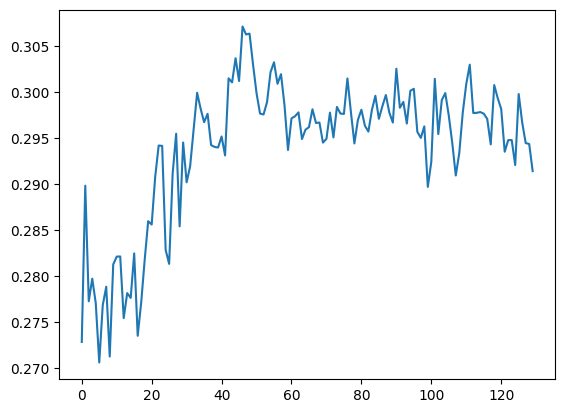

In [14]:
plt.plot(scores)
plt.show()

/var/folders/zp/wdq5n2513f916zsjngb1hs_c0000gn/T/ipykernel_32399/979258874.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))
/var/folders/zp/wdq5n2513f916zsjngb1hs_c0000gn/T/ipykernel_32399/979258874.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML



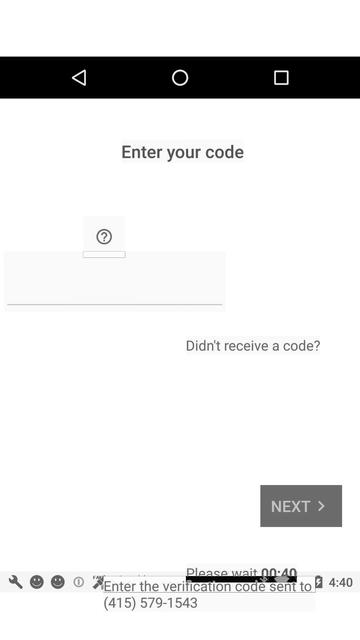

In [15]:
# Create gif from steps
import imageio

images = []
for filename in images_for_gif:
    images.append(imageio.imread(filename))

gif_filename = f"./progress_{datetime.now().isoformat(timespec='minutes')}.gif"
imageio.mimsave(gif_filename, images, loop=65535)

import base64
from IPython.core.display import display, HTML

b64 = base64.b64encode(open(gif_filename,'rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))